# Government of Canada (GC) employment by department

Public service employment source: https://www.canada.ca/en/treasury-board-secretariat/services/innovation/human-resources-statistics/population-federal-public-service-department.html

Canada population estimates source: https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1710000901

In [23]:
"""Load data from CSVs into DataFrames and normalize"""

import os

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

# Read CSVs from ./data directory to individual DataFrames
dfs = dict()
for filename in os.listdir('./data'):
    if filename.endswith('.csv'):
        dfs[filename[:-8]] = pd.read_csv('./data/' + filename)

# Load Canada population data
pop_df = pd.read_csv('./data/canada-population-esimates.csv')
pop_df = pop_df.T.reset_index()
# pop_df
pop_df.columns = ["Year", "Population"]
# Remove rows where Year doesn't start with "Q4"
pop_df = pop_df[pop_df['Year'].str.startswith('Q4')]
# Remove "Q4 " from Year column so it is just the year
pop_df['Year'] = pop_df['Year'].str.replace('Q4 ', '')
# Convert Year column to int
pop_df['Year'] = pop_df['Year'].astype(int)
# Convert Population column to int
pop_df['Population'] = pop_df['Population'].str.replace(",", "").astype(int)

# Normalize employees column to the year's population
# Year 2010 should be 1.0 because it is the base year
dfs['dept_pop_norm'] = dfs['dept'].copy()
dfs['dept_pop_norm'] = dfs['dept_pop_norm'].merge(pop_df, on='Year')
dfs['dept_pop_norm']['Employees'] = dfs['dept_pop_norm']['Employees'] / dfs['dept_pop_norm']['Population']
dfs['dept_pop_norm']['Employees'] *= pop_df.query('Year == 2010')['Population'].values[0]
dfs['dept_pop_norm'] = dfs['dept_pop_norm'].drop(columns=['Population'])
# dfs['dept_pop_norm'].head()

# What is the difference between 2023 and 2010 in the normalized data?
norm_diff = dfs["dept_pop_norm"].query("Year == 2023")["Employees"].sum() - dfs["dept_pop_norm"].query("Year == 2010")["Employees"].sum()
print("The difference between number of employees from 2010 to 2023 in the normalized data is {:.0f}".format(norm_diff))
abs_diff = dfs["dept"].query("Year == 2023")["Employees"].sum() - dfs["dept"].query("Year == 2010")["Employees"].sum()
print("The difference between number of employees from 2010 to 2023 in the raw data is {:.0f}".format(abs_diff))

The difference between number of employees from 2010 to 2023 in the normalized data is 17889
The difference between number of employees from 2010 to 2023 in the raw data is 74267


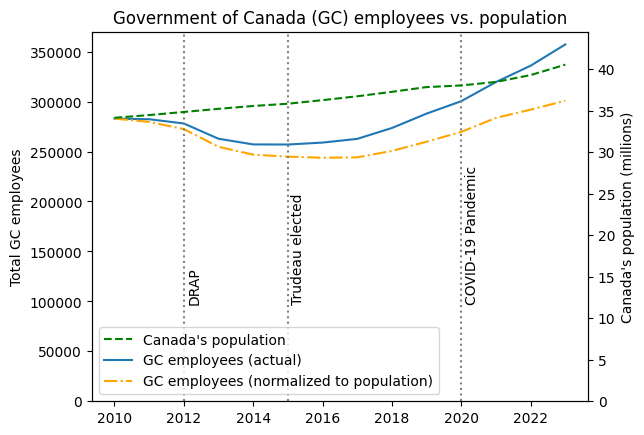

In [13]:
"""Effect of normalizing GC employees vs. population"""

normalized = dfs['dept_pop_norm'].drop(columns=['Universe']).groupby(['Year']).sum()
without_norm = dfs['dept'].drop(columns=['Universe']).groupby(['Year']).sum()
# Plot both lines on the same graph
# without_norm.plot(ylim=(0, 370000)).title.set_text('GC employees (actual vs. normalized by population)')
ln1 = plt.plot(without_norm["Employees"])
ln2 = plt.plot(normalized["Employees"], color='orange', linestyle='-.')

# Set y limits to 0, 370000
plt.ylim(0, 370000)
# Set title to "GC employees (actual vs. normalized by population)"
plt.title('Government of Canada (GC) employees vs. population')
plt.ylabel('Total GC employees')

# Draw a vertical line at 2010 for Trudeau's election
plt.axvline(x=2010, color='gray', linestyle='dotted')
# Label the vertical line
plt.text(2010.1, 100000, 'Trudeau elected', rotation=90)
# Same for pandemic in 2020
plt.axvline(x=2020, color='gray', linestyle='dotted')
plt.text(2020.1, 100000, 'COVID-19 Pandemic', rotation=90)
# Same for DRAP in 2012
plt.axvline(x=2012, color='gray', linestyle='dotted')
plt.text(2012.1, 100000, 'DRAP', rotation=90)

# Add the population of Canada to the plot with a separate axis on the right
ax2 = plt.twinx()

# Plot the population of Canada
ln3 = ax2.plot(pop_df['Year'], pop_df['Population'] / 1000000, color='green', linestyle='--')
# Set the y-axis limits
ax2.set_ylim(0, 44.5)
# Set the y-axis label
ax2.set_ylabel('Canada\'s population (millions)')

# Add a single legend for all lines
lns = ln3 + ln1 + ln2
labs = [l.get_label() for l in lns]
plt.legend(lns, ["Canada's population", "GC employees (actual)", "GC employees (normalized to population)"], loc="lower left")
plt.show()


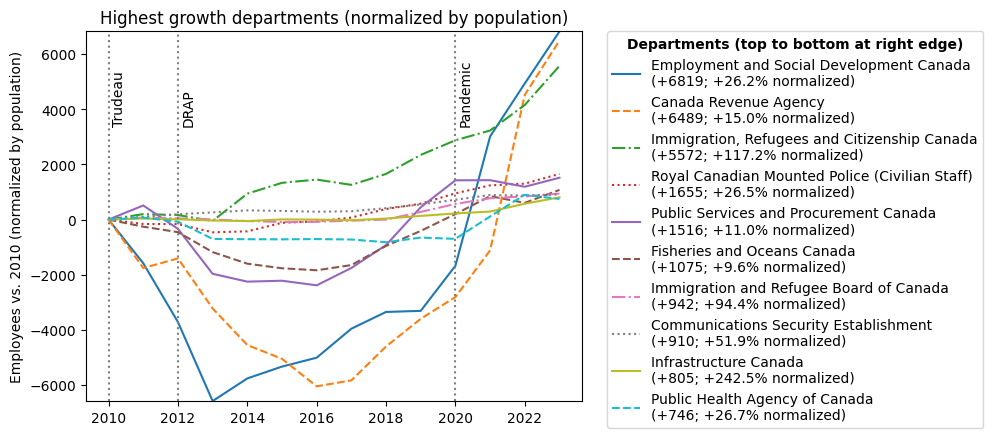

In [61]:
"""Top 10 departments by growth in absolute numbers, normalized by population"""

df = dfs["dept_pop_norm"]
df = df.drop(columns=['Universe'])

df_scaled = df.copy()
emp_2010 = df[df['Year'] == 2010]
emp_2010 = emp_2010.drop(columns=['Year']).set_index('Departments and Agencies')
df_scaled = df_scaled.merge(emp_2010, on='Departments and Agencies', how='left', suffixes=('', '_2010'))
df_scaled["Employees"] = df_scaled["Employees"] - df_scaled["Employees_2010"]

df_scaled = df_scaled.drop(columns=['Employees_2010'])

max_y = df_scaled["Employees"].max()
min_y = df_scaled["Employees"].min()

top_depts = df_scaled.query("Year == 2023").groupby(['Departments and Agencies']).sum().sort_values(by=['Employees'], ascending=False).head(10).index.tolist()

line_styles = ['-', '--', '-.', ':']
line_style_index = 0
for dept in top_depts:
    dept_size_by_year = df_scaled[df_scaled['Departments and Agencies'] == dept]
    plt.plot(dept_size_by_year['Year'], dept_size_by_year['Employees'], label=dept, linestyle=line_styles[line_style_index%len(line_styles)])
    line_style_index += 1


# Draw a vertical line at 2010 for Trudeau's election
plt.axvline(x=2010, color='gray', linestyle='dotted')
# Label the vertical line
plt.text(2010.1, 3500, 'Trudeau', rotation=90)
# Same for pandemic in 2020
plt.axvline(x=2020, color='gray', linestyle='dotted')
plt.text(2020.1, 3500, 'Pandemic', rotation=90)
# Same for DRAP in 2012
plt.axvline(x=2012, color='gray', linestyle='dotted')
plt.text(2012.1, 3500, 'DRAP', rotation=90)

# Calculate growth totals and percentage growth for each department, then add these to the legend
growth_percentages = 100 * df_scaled.set_index("Departments and Agencies").query("Year == 2023")["Employees"] / emp_2010["Employees"]

growth_totals = (
    df_scaled.set_index("Departments and Agencies").query("Year == 2023")["Employees"]
)

# Add growth totals and percentages to legend
legend_labels = []
for dept in top_depts:
    legend_labels.append(
        f"{dept}\n(+{growth_totals[dept]:.0f}; +{growth_percentages[dept]:.1f}% normalized)"
    )

plt.legend(legend_labels, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title='Departments (top to bottom at right edge)')
# Legend title should be bold and left-aligned
plt.setp(plt.gca().get_legend().get_title(), fontweight='bold')
plt.ylim(min_y, max_y)
plt.ylabel('Employees vs. 2010 (normalized by population)')
plt.title('Highest growth departments (normalized by population)')
plt.show()

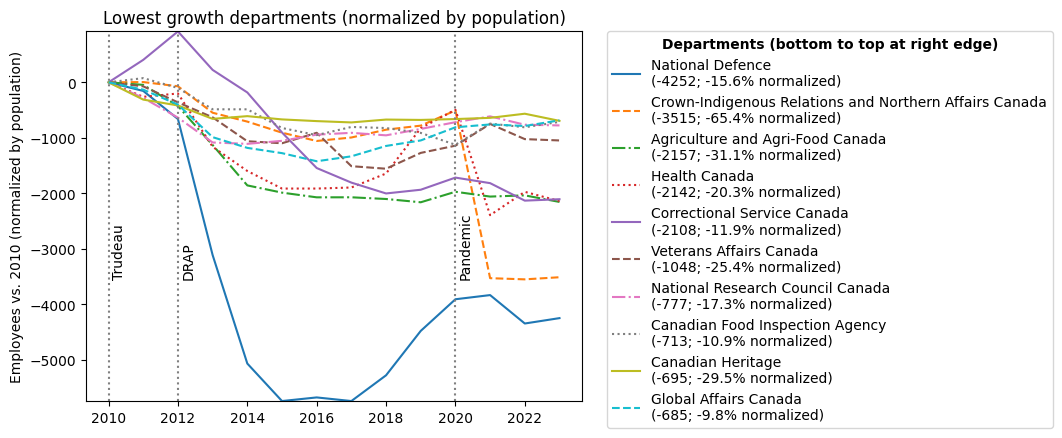

In [62]:
"""Bottom 10 departments by growth in absolute numbers (i.e. shrinking), normalized by population"""

df = dfs["dept_pop_norm"]
df = df.drop(columns=['Universe'])

df_scaled = df.copy()
emp_2010 = df[df['Year'] == 2010]
emp_2010 = emp_2010.drop(columns=['Year']).set_index('Departments and Agencies')
df_scaled = df_scaled.merge(emp_2010, on='Departments and Agencies', how='left', suffixes=('', '_2010'))
df_scaled["Employees"] = df_scaled["Employees"] - df_scaled["Employees_2010"]

df_scaled = df_scaled.drop(columns=['Employees_2010'])

top_depts = df_scaled.query("Year == 2023").groupby(['Departments and Agencies']).sum().sort_values(by=['Employees'], ascending=True).head(10).index.tolist()

df_scaled = df_scaled[df_scaled['Departments and Agencies'].isin(top_depts)]

max_y = df_scaled["Employees"].max()
min_y = df_scaled["Employees"].min()

line_styles = ['-', '--', '-.', ':']
line_style_index = 0
for dept in top_depts:
    dept_size_by_year = df_scaled[df_scaled['Departments and Agencies'] == dept]
    plt.plot(dept_size_by_year['Year'], dept_size_by_year['Employees'], label=dept, linestyle=line_styles[line_style_index%len(line_styles)])
    line_style_index += 1

# Draw a vertical line at 2010 for Trudeau's election
plt.axvline(x=2010, color='gray', linestyle='dotted')
# Label the vertical line
plt.text(2010.1, -3500, 'Trudeau', rotation=90)
# Same for pandemic in 2020
plt.axvline(x=2020, color='gray', linestyle='dotted')
plt.text(2020.1, -3500, 'Pandemic', rotation=90)
# Same for DRAP in 2012
plt.axvline(x=2012, color='gray', linestyle='dotted')
plt.text(2012.1, -3500, 'DRAP', rotation=90)


# Calculate growth totals and percentage growth for each department, then add these to the legend
growth_percentages = 100 * df_scaled.set_index("Departments and Agencies").query("Year == 2023")["Employees"] / emp_2010["Employees"]

growth_totals = (
    df_scaled.set_index("Departments and Agencies").query("Year == 2023")["Employees"]
)

# Add growth totals and percentages to legend
legend_labels = []
for dept in top_depts:
    legend_labels.append(
        f"{dept}\n({growth_totals[dept]:.0f}; {growth_percentages[dept]:.1f}% normalized)"
    )

plt.legend(legend_labels, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title='Departments (bottom to top at right edge)')

# Legend title should be bold and left-aligned
plt.setp(plt.gca().get_legend().get_title(), fontweight='bold')
plt.ylim(min_y, max_y)
plt.ylabel('Employees vs. 2010 (normalized by population)')
plt.title('Lowest growth departments (normalized by population)')
plt.show()

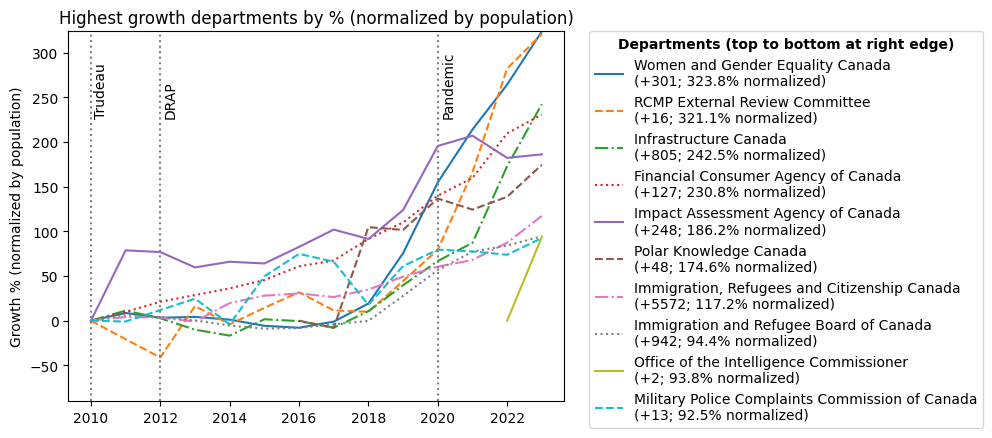

In [63]:
"""Top 10 departments (any size dept) by growth in proportional numbers, normalized by population"""

df = dfs["dept_pop_norm"]
df.replace(0, np.nan, inplace=True)
df = df.drop(columns=['Universe'])

# For each department, find the first year that it had more than 0 employees - and keep only that row.
# This is the first year that the department existed in the data.

df_first_year = df.dropna().sort_values(['Year']).groupby(['Departments and Agencies']).first().reset_index()

# For each department, normalize the number of employees to 100% in the first year that it had more than 0 employees.
# This is the ratio of employees in each year to the number of employees in the first year that the department existed.

df_growth = df.merge(df_first_year, on='Departments and Agencies', how='left', suffixes=('', '_first'))
df_growth["Employees"] = 100 * df_growth["Employees"] / df_growth["Employees_first"] - 100
df_growth = df_growth.drop(columns=['Employees_first', 'Year_first'])

# Plot the top 10 departments by growth in proportional numbers
max_y = df_growth["Employees"].max()
min_y = df_growth["Employees"].min()

top_depts = df_growth.query("Year == 2023").groupby(['Departments and Agencies']).sum().sort_values(by=['Employees'], ascending=False).head(10).index.tolist()

df_growth = df_growth[df_growth['Departments and Agencies'].isin(top_depts)]

line_styles = ['-', '--', '-.', ':']
line_style_index = 0
for dept in top_depts:
    dept_size_by_year = df_growth[df_growth['Departments and Agencies'] == dept]
    plt.plot(dept_size_by_year['Year'], dept_size_by_year['Employees'], label=dept, linestyle=line_styles[line_style_index%len(line_styles)])
    line_style_index += 1


# Draw a vertical line at 2010 for Trudeau's election
plt.axvline(x=2010, color='gray', linestyle='dotted')
# Label the vertical line
plt.text(2010.1, 230, 'Trudeau', rotation=90)
# Same for pandemic in 2020
plt.axvline(x=2020, color='gray', linestyle='dotted')
plt.text(2020.1, 230, 'Pandemic', rotation=90)
# Same for DRAP in 2012
plt.axvline(x=2012, color='gray', linestyle='dotted')
plt.text(2012.1, 230, 'DRAP', rotation=90)

# Calculate growth totals and percentage growth for each department, then add these to the legend
df_growth_tot = df.merge(df_first_year, on='Departments and Agencies', how='left', suffixes=('', '_first'))
df_growth_tot["Employees"] = df_growth_tot["Employees"] - df_growth_tot["Employees_first"]
df_growth_tot = df_growth_tot.drop(columns=['Employees_first', 'Year_first'])
growth_totals = df_growth_tot.set_index("Departments and Agencies").query("Year == 2023")["Employees"]
growth_percentages = df_growth.set_index("Departments and Agencies").query("Year == 2023")["Employees"]

# Add growth totals and percentages to legend
legend_labels = []
for dept in top_depts:
    legend_labels.append(
        f"{dept}\n(+{growth_totals[dept]:.0f}; {growth_percentages[dept]:.1f}% normalized)"
    )

plt.legend(legend_labels, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title='Departments (top to bottom at right edge)')
# Legend title should be bold
plt.setp(plt.gca().get_legend().get_title(), fontweight='bold')

plt.ylim(min_y, max_y)
plt.ylabel('Growth % (normalized by population)')
plt.title('Highest growth departments by % (normalized by population)')
plt.show()

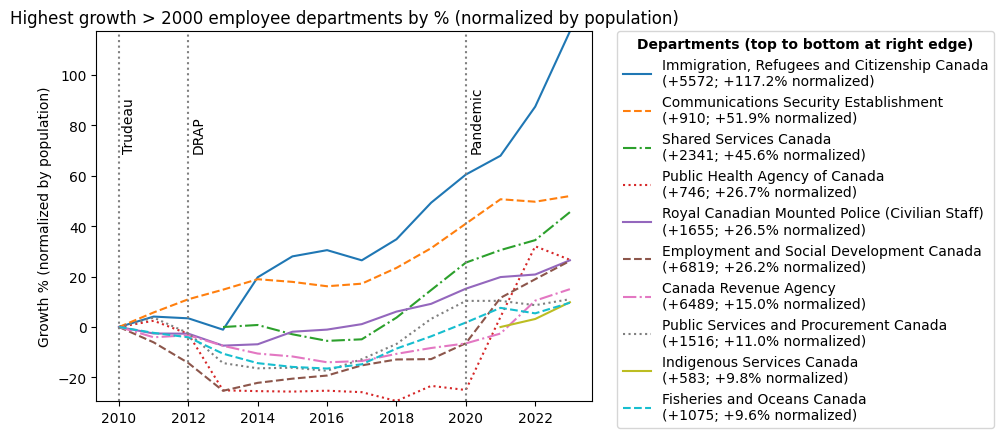

In [64]:
"""Top 10 departments (only > 2000 employees) by growth in proportional numbers, normalized by population"""

df = dfs["dept_pop_norm"]
df.replace(0, np.nan, inplace=True)
df = df.drop(columns=['Universe'])

# For each department, find the first year that it had more than 0 employees - and keep only that row.
# This is the first year that the department existed in the data.

df_first_year = df.dropna().sort_values(['Year']).groupby(['Departments and Agencies']).first().reset_index()
df_first_year

# For each department, normalize the number of employees to 100% in the first year that it had more than 0 employees.
# This is the ratio of employees in each year to the number of employees in the first year that the department existed.

df_growth = df.merge(df_first_year, on='Departments and Agencies', how='left', suffixes=('', '_first'))

# Filter to only departments which had more than 2000 employees in any year
large_depts = df_growth.groupby(['Departments and Agencies']).max().sort_values(by=['Employees'], ascending=False).query("Employees > 2000").index.tolist()
df_growth = df_growth[df_growth['Departments and Agencies'].isin(large_depts)]

df_growth["Employees"] = 100 * df_growth["Employees"] / df_growth["Employees_first"] - 100
df_growth = df_growth.drop(columns=['Employees_first', 'Year_first'])

top_depts = df_growth.query("Year == 2023").groupby(['Departments and Agencies']).sum().sort_values(by=['Employees'], ascending=False).head(10).index.tolist()

df_growth = df_growth[df_growth['Departments and Agencies'].isin(top_depts)]
# Plot the top 10 departments by growth in proportional numbers
max_y = df_growth["Employees"].max()
min_y = df_growth["Employees"].min()

line_styles = ['-', '--', '-.', ':']
line_style_index = 0
for dept in top_depts:
    dept_size_by_year = df_growth[df_growth['Departments and Agencies'] == dept]
    plt.plot(dept_size_by_year['Year'], dept_size_by_year['Employees'], label=dept, linestyle=line_styles[line_style_index%len(line_styles)])
    line_style_index += 1


# Draw a vertical line at 2010 for Trudeau's election
plt.axvline(x=2010, color='gray', linestyle='dotted')
# Label the vertical line
plt.text(2010.1, 70, 'Trudeau', rotation=90)
# Same for pandemic in 2020
plt.axvline(x=2020, color='gray', linestyle='dotted')
plt.text(2020.1, 70, 'Pandemic', rotation=90)
# Same for DRAP in 2012
plt.axvline(x=2012, color='gray', linestyle='dotted')
plt.text(2012.1, 70, 'DRAP', rotation=90)

# Calculate growth totals and percentage growth for each department, then add these to the legend
df_growth_tot = df.merge(df_first_year, on='Departments and Agencies', how='left', suffixes=('', '_first'))
df_growth_tot["Employees"] = df_growth_tot["Employees"] - df_growth_tot["Employees_first"]
df_growth_tot = df_growth_tot.drop(columns=['Employees_first', 'Year_first'])
growth_totals = df_growth_tot.set_index("Departments and Agencies").query("Year == 2023")["Employees"]
growth_percentages = df_growth.set_index("Departments and Agencies").query("Year == 2023")["Employees"]

# Add growth totals and percentages to legend
legend_labels = []
for dept in top_depts:
    legend_labels.append(
        f"{dept}\n(+{growth_totals[dept]:.0f}; +{growth_percentages[dept]:.1f}% normalized)"
    )

plt.legend(legend_labels, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title='Departments (top to bottom at right edge)')
# Legend title should be bold
plt.setp(plt.gca().get_legend().get_title(), fontweight='bold')

plt.ylim(min_y, max_y)
plt.ylabel('Growth % (normalized by population)')
plt.title('Highest growth > 2000 employee departments by % (normalized by population)')
plt.show()

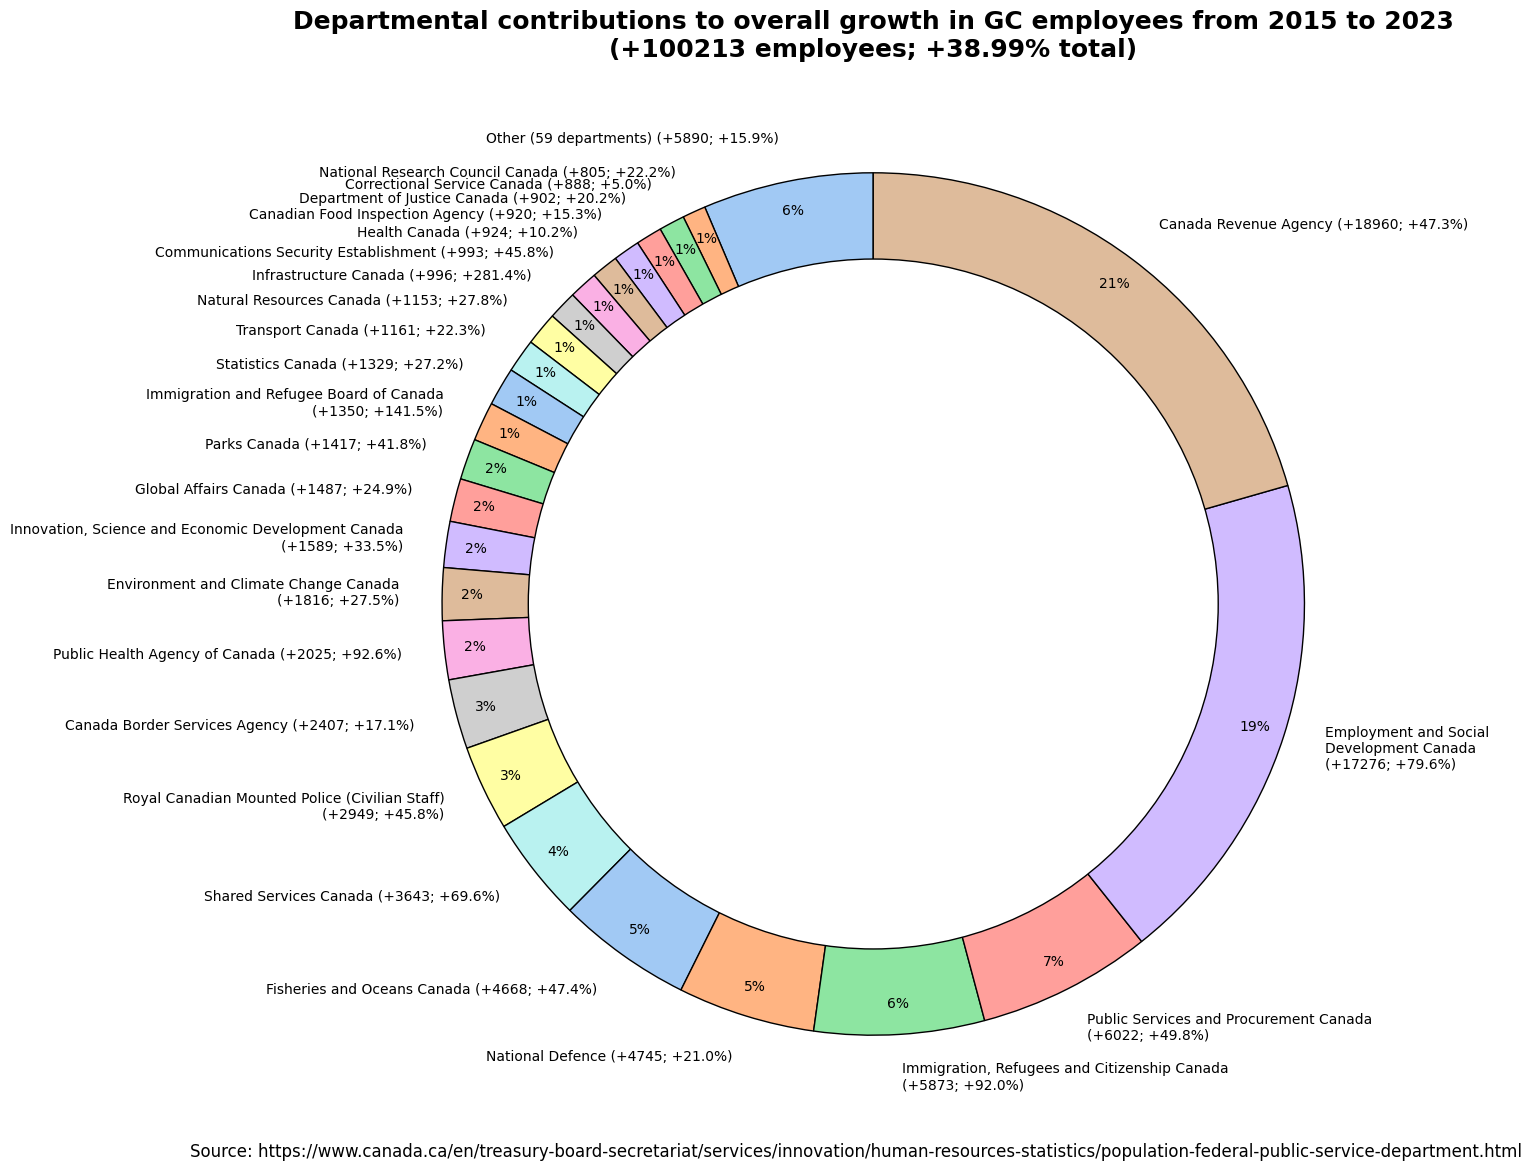

In [66]:
"""Departmental contribution to overall growth in GC employees under Trudeau"""

df = dfs["dept"]
df = df.drop(columns=["Universe"])

# What is the absolute difference between 2023 values and 2015 values, for each department?
df_2023 = df[df["Year"] == 2023]
df_2015 = df[df["Year"] == 2015]
df_2015 = df_2015.drop(columns=["Year"])
df_2015 = df_2015.set_index("Departments and Agencies")
df_2023 = df_2023.drop(columns=["Year"])
df_2023 = df_2023.set_index("Departments and Agencies")

# Find the difference between 2023 and 2015
total_diff = df_2023["Employees"].sum() - df_2015["Employees"].sum()
percent_diff = 100 * df_2023["Employees"].sum() / df_2015["Employees"].sum() - 100

df_diff = df_2023 - df_2015
df_diff = df_diff.reset_index()
df_diff = df_diff.sort_values(by=["Employees"], ascending=False)
# Pie chart of all departments by Diff
df_diff = df_diff.sort_values(by=["Employees"], ascending=True)
# Group the smallest growth departments together
# How many small departments?
min_size = 800
num_small = df_diff[df_diff["Employees"] < min_size].shape[0]
other_name = f"Other ({num_small} departments)"
df_diff.loc[df_diff["Employees"] < min_size, "Departments and Agencies"] = other_name
df_diff = df_diff.groupby(["Departments and Agencies"]).sum().reset_index()
df_diff = df_diff.sort_values(by=["Employees"], ascending=True)
# Put the "other" category last
df_diff2 = df_diff[df_diff["Departments and Agencies"] != other_name]
df_diff2 = pd.concat(
    [
        df_diff[df_diff["Departments and Agencies"] == other_name],
        df_diff2,
    ]
)
# Drop rows with 0 employees
df_diff2 = df_diff2[df_diff2["Employees"] != 0]
# Find the % increase for each of the departments in df_diff2
# First, combine the departments NOT in df_diff2 into the other_name category
df_2015 = df_2015.reset_index()
df_2015.loc[~(df_2015["Departments and Agencies"].isin(df_diff2["Departments and Agencies"])), "Departments and Agencies"] = other_name
df_2015 = df_2015.groupby(["Departments and Agencies"]).sum().reset_index()
df_diff2 = df_diff2.merge(
    df_2015, on="Departments and Agencies", how="left", suffixes=("", "_2015")
)
df_diff2["% increase"] = (
    100 * df_diff2["Employees"] / df_diff2["Employees_2015"]
)
# Replace zero with infinity symbol
df_diff2["% increase"] = df_diff2["% increase"].replace(np.inf, "∞")
# Round to 1 decimal place
df_diff2["% increase"] = df_diff2["% increase"].round(1)

df_diff2["Departments and Agencies"] = df_diff2["Departments and Agencies"].replace(
    "Employment and Social Development Canada",
    "Employment and Social\nDevelopment Canada",
)
# Add the absolute number and % to the end of the "Departments and Agencies" column in parens
df_diff2["Departments and Agencies"] = (
    df_diff2["Departments and Agencies"]
    + " (+"
    + df_diff2["Employees"].astype(int).astype(str)
    # + ")"
    + "; +"
    + df_diff2["% increase"].astype(str)
    + "%)"
)
# If the line is too long (X chars), add a line break before the parentheses
# Or if its one the following:
line_break_depts = [
    "Innovation, Science and Economic Development Canada",
    "Environment and Climate Change Canada",
]
df_diff2["Departments and Agencies"] = df_diff2["Departments and Agencies"].apply(
    lambda x: x.replace(" (+", "\n(+") if len(x) > 53 or x.split("(")[0].strip() in line_break_depts else x
)

df_diff2.plot.pie(
    y="Employees",
    labels=df_diff2["Departments and Agencies"],
    figsize=(14, 14),
    autopct="%1.0f%%",
    startangle=90,
    legend=False,
    # Light pastel colors for text contrast
    colors=sns.color_palette("pastel"),
    # The slices should have a black outline
    wedgeprops={"linewidth": 1, "edgecolor": "black"},
    # Only show the percent labels if the slice is large enough
    pctdistance=0.93,
)
# Don't show the y-axis label
plt.ylabel("")
# Left-align the title
plt.title(
    (
        "Departmental contributions to overall growth in GC employees from 2015 to 2023\n"
        f"(+{total_diff} employees; +{percent_diff:.2f}% total)"
    ),
    fontsize=18,
    fontdict=(
        # Bold the title
        {"fontweight": "bold"}
    ),
)
# Take out the middle of the pie chart to make it a donut
centre_circle = plt.Circle((0, 0), 0.8, fc="white")
# The circle needs a border like the slices, black and 1px wide
centre_circle.set_edgecolor("black")
centre_circle.set_linewidth(1)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Add source text to the bottom
plt.figtext(
    0.5,
    0.1,
    "Source: https://www.canada.ca/en/treasury-board-secretariat/services/innovation/human-resources-statistics/population-federal-public-service-department.html",
    ha="center",
    fontsize=12,
)
plt.show()


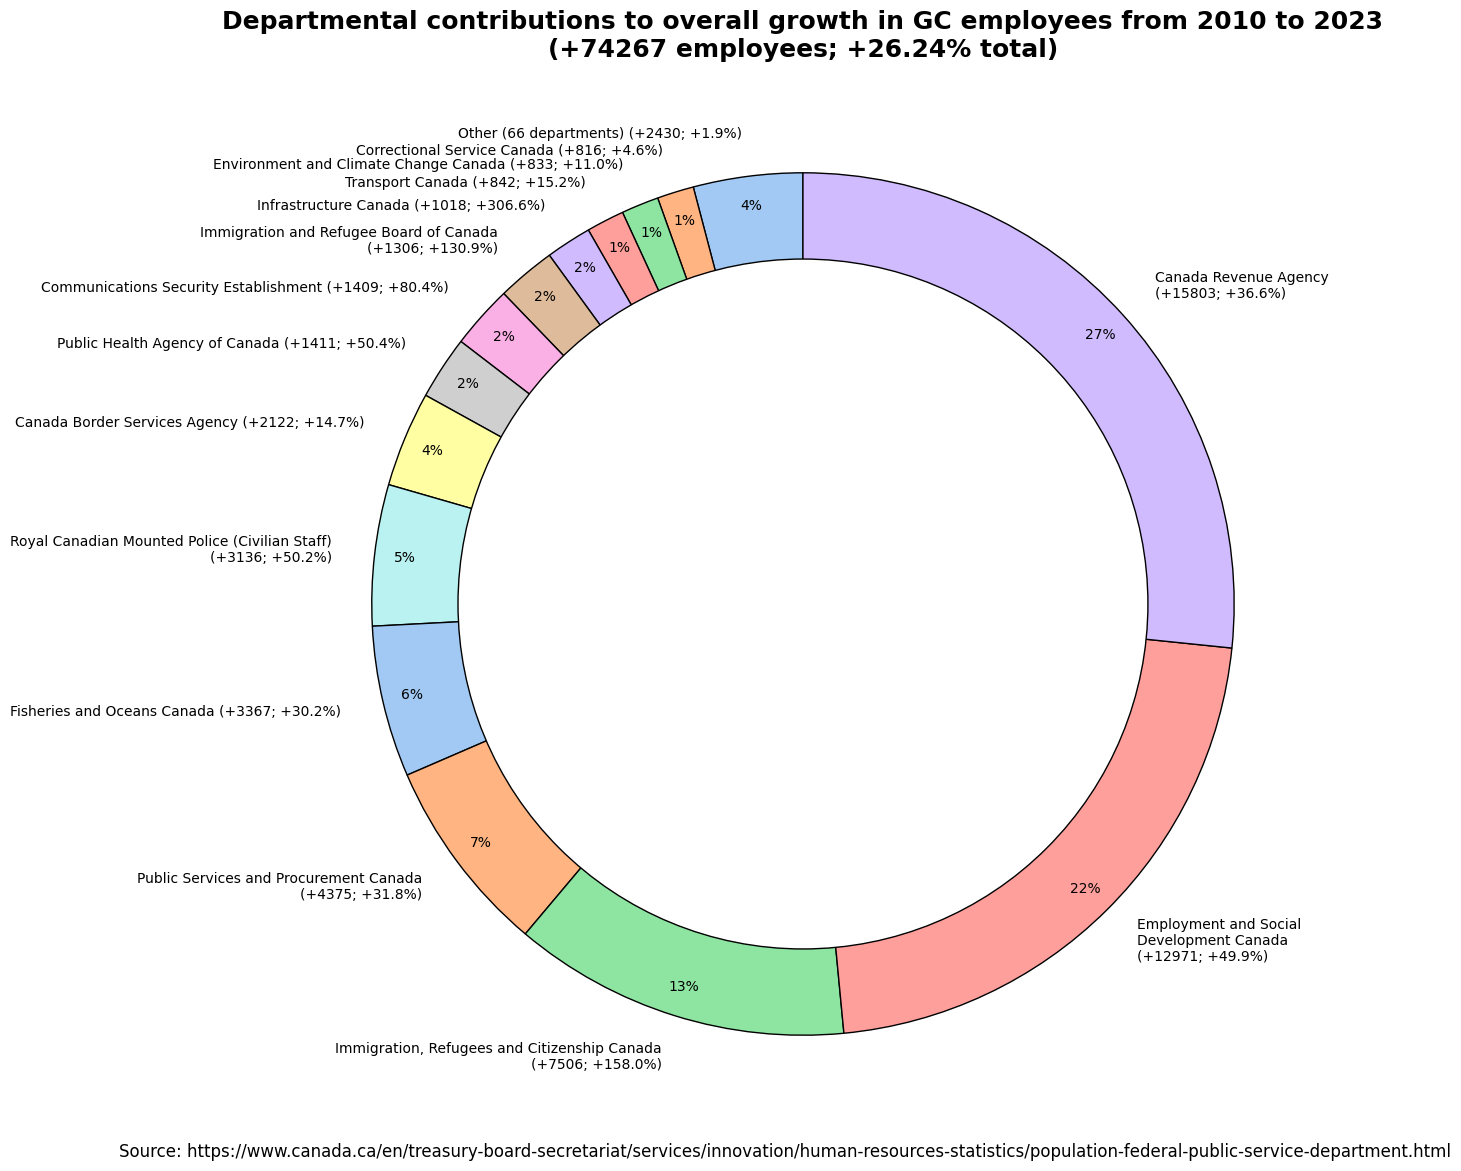

In [67]:
"""Departmental contribution to overall growth in GC employees under Trudeau"""

df = dfs["dept"]
df = df.drop(columns=["Universe"])

# What is the absolute difference between 2023 values and 2010 values, for each department?
df_2023 = df[df["Year"] == 2023]
df_2010 = df[df["Year"] == 2010]
df_2010 = df_2010.drop(columns=["Year"])
df_2010 = df_2010.set_index("Departments and Agencies")
df_2023 = df_2023.drop(columns=["Year"])
df_2023 = df_2023.set_index("Departments and Agencies")

# Find the difference between 2023 and 2010
total_diff = df_2023["Employees"].sum() - df_2010["Employees"].sum()
percent_diff = 100 * df_2023["Employees"].sum() / df_2010["Employees"].sum() - 100

df_diff = df_2023 - df_2010
df_diff = df_diff.reset_index()
df_diff = df_diff.sort_values(by=["Employees"], ascending=False)
# Pie chart of all departments by Diff
df_diff = df_diff.sort_values(by=["Employees"], ascending=True)
# Group the smallest growth departments together
# How many small departments?
min_size = 800
num_small = df_diff[df_diff["Employees"] < min_size].shape[0]
other_name = f"Other ({num_small} departments)"
df_diff.loc[df_diff["Employees"] < min_size, "Departments and Agencies"] = other_name
df_diff = df_diff.groupby(["Departments and Agencies"]).sum().reset_index()
df_diff = df_diff.sort_values(by=["Employees"], ascending=True)
# Put the "other" category last
df_diff2 = df_diff[df_diff["Departments and Agencies"] != other_name]
df_diff2 = pd.concat(
    [
        df_diff[df_diff["Departments and Agencies"] == other_name],
        df_diff2,
    ]
)
# Drop rows with 0 employees
df_diff2 = df_diff2[df_diff2["Employees"] != 0]
# Find the % increase for each of the departments in df_diff2
# First, combine the departments NOT in df_diff2 into the other_name category
df_2010 = df_2010.reset_index()
df_2010.loc[~(df_2010["Departments and Agencies"].isin(df_diff2["Departments and Agencies"])), "Departments and Agencies"] = other_name
df_2010 = df_2010.groupby(["Departments and Agencies"]).sum().reset_index()
df_diff2 = df_diff2.merge(
    df_2010, on="Departments and Agencies", how="left", suffixes=("", "_2010")
)
df_diff2["% increase"] = (
    100 * df_diff2["Employees"] / df_diff2["Employees_2010"]
)
# Replace zero with infinity symbol
df_diff2["% increase"] = df_diff2["% increase"].replace(np.inf, "∞")
# Round to 1 decimal place
df_diff2["% increase"] = df_diff2["% increase"].round(1)

df_diff2["Departments and Agencies"] = df_diff2["Departments and Agencies"].replace(
    "Employment and Social Development Canada",
    "Employment and Social\nDevelopment Canada",
)
# Add the absolute number and % to the end of the "Departments and Agencies" column in parens
df_diff2["Departments and Agencies"] = (
    df_diff2["Departments and Agencies"]
    + " (+"
    + df_diff2["Employees"].astype(int).astype(str)
    # + ")"
    + "; +"
    + df_diff2["% increase"].astype(str)
    + "%)"
)
# If the line is too long (X chars), add a line break before the parentheses
# Or if its one the following:
line_break_depts = [
    "Innovation, Science and Economic Development Canada",
    "Canada Revenue Agency"
]
df_diff2["Departments and Agencies"] = df_diff2["Departments and Agencies"].apply(
    lambda x: x.replace(" (+", "\n(+") if len(x) > 53 or x.split("(")[0].strip() in line_break_depts else x
)

df_diff2.plot.pie(
    y="Employees",
    labels=df_diff2["Departments and Agencies"],
    figsize=(14, 14),
    autopct="%1.0f%%",
    startangle=90,
    legend=False,
    # Light pastel colors for text contrast
    colors=sns.color_palette("pastel"),
    # The slices should have a black outline
    wedgeprops={"linewidth": 1, "edgecolor": "black"},
    # Only show the percent labels if the slice is large enough
    pctdistance=0.93,
)
# Don't show the y-axis label
plt.ylabel("")
# Left-align the title
plt.title(
    (
        "Departmental contributions to overall growth in GC employees from 2010 to 2023\n"
        f"(+{total_diff} employees; +{percent_diff:.2f}% total)"
    ),
    fontsize=18,
    fontdict=(
        # Bold the title
        {"fontweight": "bold"}
    ),
)
# Take out the middle of the pie chart to make it a donut
centre_circle = plt.Circle((0, 0), 0.8, fc="white")
# The circle needs a border like the slices, black and 1px wide
centre_circle.set_edgecolor("black")
centre_circle.set_linewidth(1)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Add source text to the bottom
plt.figtext(
    0.5,
    0.1,
    "Source: https://www.canada.ca/en/treasury-board-secretariat/services/innovation/human-resources-statistics/population-federal-public-service-department.html",
    ha="center",
    fontsize=12,
)
plt.show()


In [69]:
"""Departmental breakdown of GC employees over time, not normalized"""

# stacked area chart of the top departments by employees per year
# group all but the top departments into "other"
# then plot the top depts + other with plotly

df = dfs["dept"]
df = df.drop(columns=["Universe"])

# top 10 departments by employees overall
top_depts = df.groupby(['Departments and Agencies']).sum().sort_values(by=['Employees'], ascending=False).head(30).index.tolist()

all_depts = df["Departments and Agencies"].unique().tolist()
num_other_depts = len(all_depts) - len(top_depts)
# group all but the top 10 departments into "other"
other_str = f"Other ({num_other_depts} smallest departments)"
df["Departments and Agencies"] = df["Departments and Agencies"].apply(lambda x: x if x in top_depts else other_str)

# group by year and department
df = df.groupby(['Year', 'Departments and Agencies']).sum().reset_index()

# Update the department column names to include the number of employees in 2023
# This will be used as the legend
df_2023 = df[df["Year"] == 2023]
df_2023 = df_2023.drop(columns=["Year"])
df_2023 = df_2023.set_index("Departments and Agencies")
df = df.merge(df_2023, on="Departments and Agencies", how="left", suffixes=("", "_2023"))
df.sort_values(by=["Employees_2023"], ascending=False, inplace=True)
# Calculate 2023 employees - 2010 employees
df_2010 = df[df["Year"] == 2010]
df_2010.fillna(0, inplace=True)
df_2010 = df_2010.drop(columns=["Year"])
df_2010 = df_2010.set_index("Departments and Agencies")
df = df.merge(df_2010, on="Departments and Agencies", how="left", suffixes=("", "_2010"))
df.fillna(0, inplace=True)
df["Employee Diff"] = df["Employees_2023"] - df["Employees_2010"]
# Format to round to 0 decimals and have a + symbol if positive.
df["Employee Diff"] = df["Employee Diff"].apply(lambda x: f"+{int(x):.0f}" if x > 0 else f"{int(x):.0f}")
df["Departments and Agencies"] = (
    df["Departments and Agencies"]
    + " ("
    + df["Employees_2023"].astype(int).astype(str)
    + "; "
    + df["Employee Diff"].astype(str)
    + ")"
)
dept_names = df["Departments and Agencies"].tolist()

# pivot to wide format
df = df.pivot(index='Year', columns='Departments and Agencies', values='Employees').reset_index()

# plot with plotly
import plotly.express as px

fig = px.area(df, x="Year", y=dept_names, title='GC employees by department, 2010 to 2023')

# Add vertical lines for Trudeau, DRAP and Pandemic
for year, label in zip([2010, 2012, 2020], ['Trudeau', 'DRAP', 'Pandemic']):
    fig.add_vline(x=year, line_width=1, line_dash="dot", line_color="black")
    # Rotate label 90 degrees
    fig.add_annotation(
        x=year,
        y=340000,
        text=label,
        showarrow=False,
        textangle=-90,
        xanchor="left",
        xshift=5,
        font=dict(
            size=12,
            color="black"
        )
    )

# Add source text to the bottom
fig.add_annotation(
    xref="paper",
    yref="paper",
    x=-0.15,
    y=-0.12,
    text="Source: https://www.canada.ca/en/treasury-board-secretariat/services/innovation/human-resources-statistics/population-federal-public-service-department.html",
    showarrow=False,
)

# Change legend title
fig.update_layout(legend_title_text='Department (2023 employees; change); bottom to top on graph')
# y-axis label
fig.update_yaxes(title_text='GC employees by department')

# Change height to make it more square
fig.update_layout(height=800, width=1100)
fig.show()

/tmp/ipykernel_1520/2695817977.py:31: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [52]:
"""Change in GC employees over time by department, normalized to population"""

df = dfs["dept_pop_norm"]
df = df.drop(columns=['Universe'])

df_scaled = df.copy()
emp_2010 = df[df['Year'] == 2010]
emp_2010 = emp_2010.drop(columns=['Year']).set_index('Departments and Agencies')
df_scaled = df_scaled.merge(emp_2010, on='Departments and Agencies', how='left', suffixes=('', '_2010'))
df_scaled["Employees"] = df_scaled["Employees"] - df_scaled["Employees_2010"]

df_scaled = df_scaled.drop(columns=['Employees_2010'])

max_y = df_scaled["Employees"].max()
min_y = df_scaled["Employees"].min()

top_depts = df_scaled.query("Year == 2023").groupby(['Departments and Agencies']).sum().abs().sort_values(by=['Employees'], ascending=False).head(9).index.tolist()

df = df_scaled
# group all but the top 10 departments into "other"
num_other_depts = len(df["Departments and Agencies"].unique().tolist()) - len(top_depts)
df["Departments and Agencies"] = df["Departments and Agencies"].apply(lambda x: x if x in top_depts else "Other")

# rename "Other" to "Other (xx least changed departments)"
df["Departments and Agencies"] = df["Departments and Agencies"].apply(lambda x: x if x != "Other" else f"Other ({num_other_depts} least changed departments)")

# group by year and department
df = df.groupby(['Year', 'Departments and Agencies']).sum().reset_index()

# Update the department column names to include the number of employees in 2023
# This will be used as the legend
df_2023 = df[df["Year"] == 2023]
df_2023 = df_2023.drop(columns=["Year"])
df_2023 = df_2023.set_index("Departments and Agencies")
df = df.merge(df_2023, on="Departments and Agencies", how="left", suffixes=("", "_2023"))

# cast employees to int
df["Employees"] = df["Employees"].astype(int)
df.sort_values(by=["Employees_2023"], ascending=False, inplace=True)
df["Departments and Agencies"] = (
    df["Departments and Agencies"]
    + " ("
    + df['Employees_2023'].apply(lambda x: f"+{int(x)}" if x > 0 else f"{int(x)}").astype(str)
    + ")"
)

depts = df["Departments and Agencies"].unique().tolist()

# pivot to wide format
df = df.pivot(index='Year', columns='Departments and Agencies', values='Employees').reset_index()

# plot with plotly
import plotly.express as px

fig = px.area(df, x="Year", y=depts, title='Change in GC employees from 2010 to 2023 (departments with most change, normalized by population)')

# legend title
fig.update_layout(legend_title_text='Department (change 2010 to 2023); bottom to top on graph')

# y-axis label
fig.update_yaxes(title_text='Change in employees (normalized by population)')

# Add vertical lines for Trudeau, DRAP and Pandemic
for year, label in zip([2010, 2012, 2020], ['Trudeau', 'DRAP', 'Pandemic']):
    fig.add_vline(x=year, line_width=1, line_dash="dot", line_color="black")
    # Rotate label 90 degrees
    fig.add_annotation(
        x=year,
        y=15000,
        text=label,
        showarrow=False,
        textangle=-90,
        xanchor="left",
        xshift=5,
        font=dict(
            size=12,
            color="black"
        )
    )

fig.show()